In [ ]:
import os
import glob
from PIL import Image

root_path = r"D:\LLM\heatmaps"
target_size = (224, 224)

image_files = glob.glob(os.path.join(root_path, "*.png"))
for img_path in image_files:
    img = Image.open(img_path).convert("RGB")
    img_resized = img.resize(target_size, Image.Resampling.LANCZOS)
    img_resized.save(img_path.replace(".png", "_processed.png"))

In [13]:
!pip install open_clip_torch

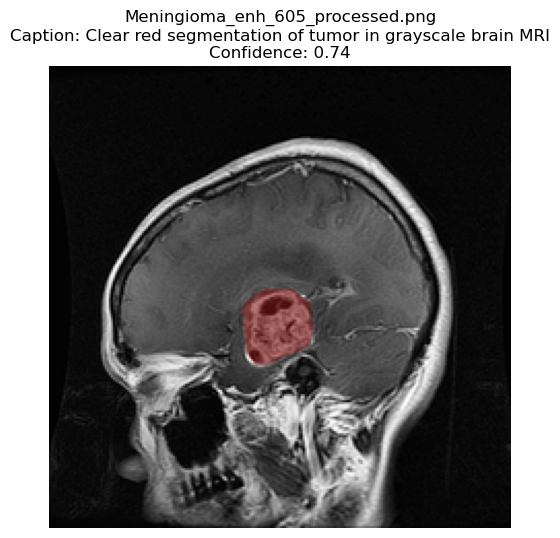

Meningioma_enh_605_processed.png:
Predicted Caption: Clear red segmentation of tumor in grayscale brain MRI
Confidence: 0.74
--------------------------------------------------------------------------------


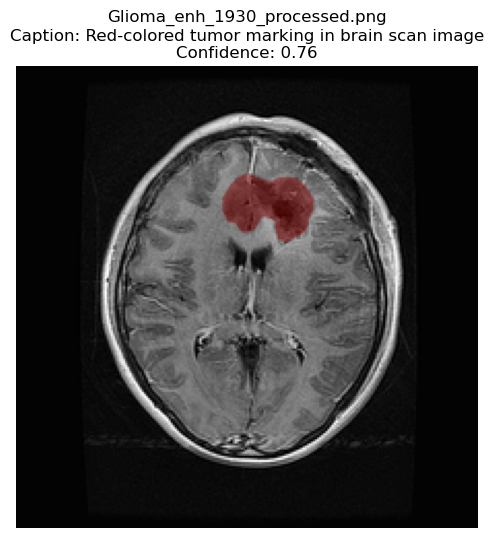

Glioma_enh_1930_processed.png:
Predicted Caption: Red-colored tumor marking in brain scan image
Confidence: 0.76
--------------------------------------------------------------------------------


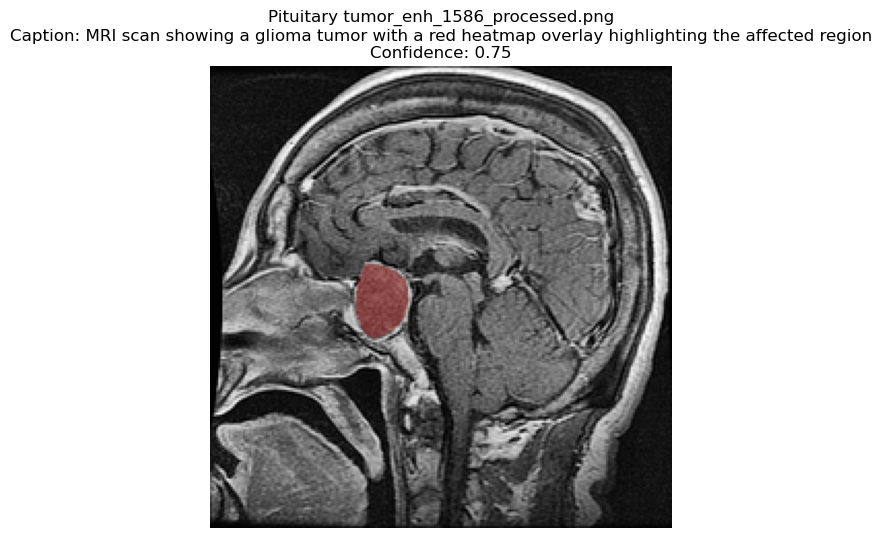

Pituitary tumor_enh_1586_processed.png:
Predicted Caption: MRI scan showing a glioma tumor with a red heatmap overlay highlighting the affected region
Confidence: 0.75
--------------------------------------------------------------------------------


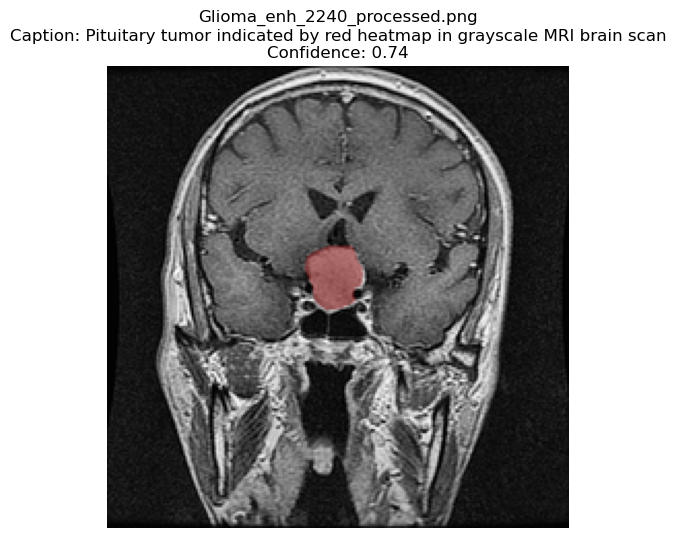

Glioma_enh_2240_processed.png:
Predicted Caption: Pituitary tumor indicated by red heatmap in grayscale MRI brain scan
Confidence: 0.74
--------------------------------------------------------------------------------


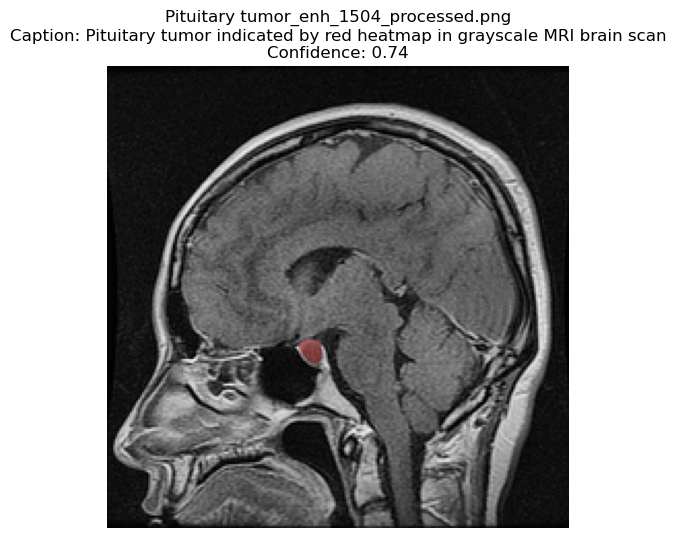

Pituitary tumor_enh_1504_processed.png:
Predicted Caption: Pituitary tumor indicated by red heatmap in grayscale MRI brain scan
Confidence: 0.74
--------------------------------------------------------------------------------


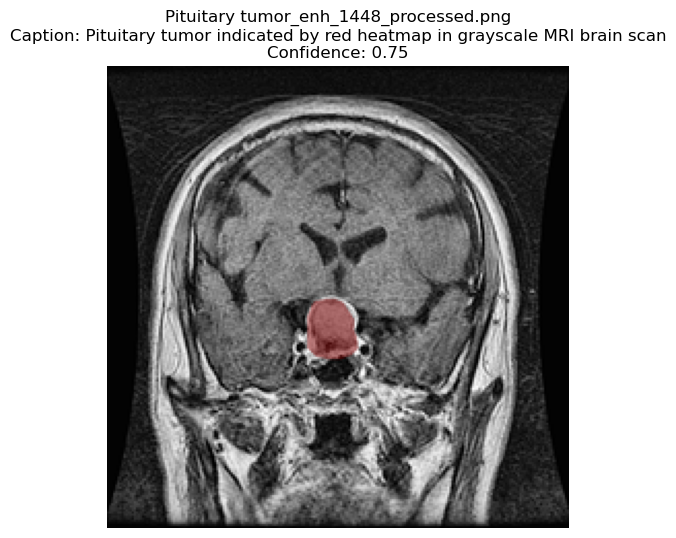

Pituitary tumor_enh_1448_processed.png:
Predicted Caption: Pituitary tumor indicated by red heatmap in grayscale MRI brain scan
Confidence: 0.75
--------------------------------------------------------------------------------


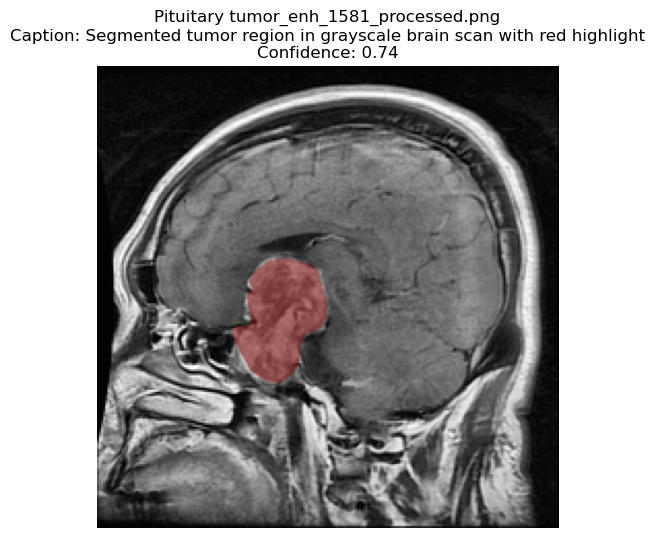

Pituitary tumor_enh_1581_processed.png:
Predicted Caption: Segmented tumor region in grayscale brain scan with red highlight
Confidence: 0.74
--------------------------------------------------------------------------------


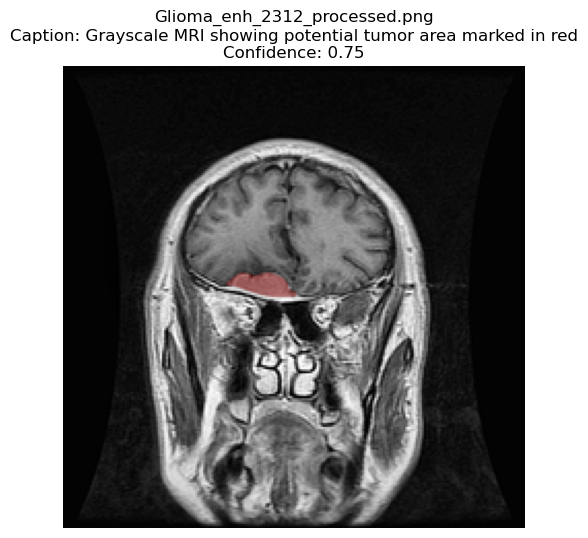

Glioma_enh_2312_processed.png:
Predicted Caption: Grayscale MRI showing potential tumor area marked in red
Confidence: 0.75
--------------------------------------------------------------------------------


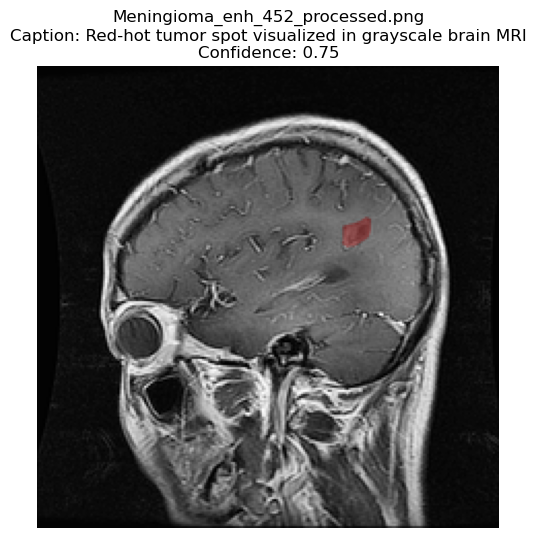

Meningioma_enh_452_processed.png:
Predicted Caption: Red-hot tumor spot visualized in grayscale brain MRI
Confidence: 0.75
--------------------------------------------------------------------------------


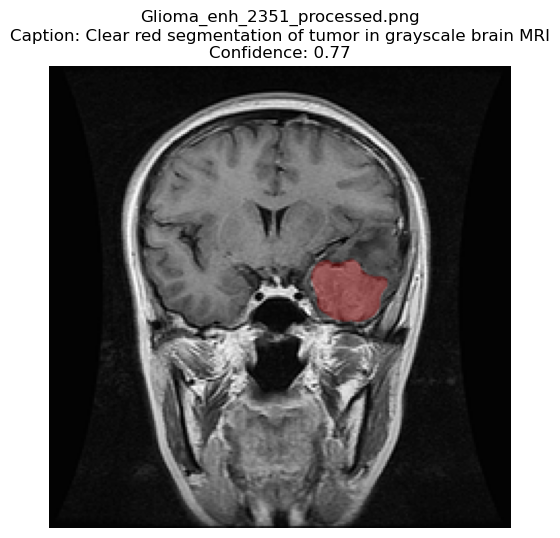

Glioma_enh_2351_processed.png:
Predicted Caption: Clear red segmentation of tumor in grayscale brain MRI
Confidence: 0.77
--------------------------------------------------------------------------------


In [9]:
import os
import glob
from PIL import Image
import torch
import open_clip
import matplotlib.pyplot as plt
import random

model_name = "hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224"
model, preprocess = open_clip.create_model_from_pretrained(model_name)
tokenizer = open_clip.get_tokenizer(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

root_path = r"D:\LLM\heatmaps"
image_files = glob.glob(os.path.join(root_path, "*_processed.png"))

labels = [
    # Tumor captions
    "MRI scan showing a glioma tumor with a red heatmap overlay highlighting the affected region",
    "Meningioma tumor visible in brain MRI with red heatmap focusing on the abnormal mass",
    "Pituitary tumor indicated by red heatmap in grayscale MRI brain scan",
    "Red heatmap in brain MRI scan indicates abnormal tumor growth",
    "Brain MRI with strong red heatmap activation around suspected tumor",
    "Segmented tumor region in grayscale brain scan with red highlight",
    "Localized brain tumor with clear red heatmap in medical scan",
    "Medical brain scan showing tumor in red over grayscale MRI",
    "Grayscale MRI showing potential tumor area marked in red",
    "Abnormal tissue detected with red heatmap overlay in brain MRI",
    "MRI showing aggressive tumor highlighted in red heatmap",
    "Red-hot tumor spot visualized in grayscale brain MRI",
    "Brain scan heatmap shows focal lesion in red",
    "Clear red segmentation of tumor in grayscale brain MRI",
    "Red-colored tumor marking in brain scan image",
    "Contrast-enhanced MRI showing a red-marked tumor site",
    "Brain tumor region localized via red thermal-like overlay",

    # No-tumor captions
    "Normal grayscale brain MRI with no abnormal findings or heatmap overlays",
    "Healthy brain scan with no tumor detected and no red highlights",
    "Grayscale MRI showing typical brain anatomy without signs of tumor",
    "Brain MRI with no evidence of abnormal growth or red heatmap region",
    "No signs of tumor present in the grayscale brain scan",
    "Clean brain MRI showing no heatmap or suspicious tumor activity",
    "Standard brain MRI image with no visible pathology",
    "Healthy brain MRI — no segmentation or red regions detected"
]


text_inputs = tokenizer(labels).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# num_images_to_show = 50
num_images=random.sample(image_files,10)
'''
for img_path in image_files[:num_images_to_show]:
    image = Image.open(img_path).convert("RGB")
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_tensor)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        similarities = (image_features @ text_features.T).squeeze(0)
        top_idx = similarities.argmax().item()
        caption = labels[top_idx]

        raw_conf = similarities[top_idx].item()
        confidence = (raw_conf + 1) / 2
'''
for img_path in num_images:
    image = Image.open(img_path).convert("RGB")
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_tensor)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        similarities = (image_features @ text_features.T).squeeze(0)
        top_idx = similarities.argmax().item()
        caption = labels[top_idx]

        raw_conf = similarities[top_idx].item()
        confidence = (raw_conf + 1) / 2
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(f"{os.path.basename(img_path)}\nCaption: {caption}\nConfidence: {confidence:.2f}")
    plt.axis("off")
    plt.show()

    print(f"{os.path.basename(img_path)}:")
    print(f"Predicted Caption: {caption}")
    print(f"Confidence: {confidence:.2f}")
    print("-" * 80)
